# FishVista Patching

We operate at the patch/token level (the ViT’s representation), so we need patch-level labels even when pixel-level masks exist. The pixel segmentation is used only to derive an upper-bound supervision signal that matches our model’s resolution and the evaluation granularity. In other words, we collapse pixels -> patches to ask: "If a linear classifier had perfect patch labels, how well could patch-level prediction perform?" There’s no benefit to pushing the baseline down to pixels when the true task and metrics are defined over patches.

When collapsing pixels to a single patch label, we considered two "mode" rules. A vanilla mode often returns background because background dominates most patches, even when a meaningful object/trait is present. We therefore use a foreground-prior mode: compute the per-patch histogram, ignore the background count, and pick the most frequent non-background class if any exists; only assign background when the patch is 100% background. This better reflects our goal (detecting the presence of diagnostic content within a patch), reduces background bias at boundaries, and still behaves conservatively on empty patches. A minimum-coverage threshold can be added as a sensitivity check if needed.

Below, you can see examples of:

1. The original pixel-level labels
2. The original "mode" patch-level labels
3. The proposed background-aware patch-level labels

In [18]:
import colorsys

import einops
import numpy as np
import torch
from PIL import Image
from torchvision.transforms import v2

import saev.data.transforms

In [19]:
cfg = saev.data.images.SegFolder(
    root="/fs/scratch/PAS2136/samuelstevens/datasets/fish-vista-segfolder",
    img_label_fname="image_labels.txt",
)

img_transform = v2.Compose([
    saev.data.transforms.FlexResize(patch_size=16, n_patches=640),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.4850, 0.4560, 0.4060], std=[0.2290, 0.2240, 0.2250]),
])

seg_transform = v2.Compose([
    saev.data.transforms.FlexResize(
        patch_size=16, n_patches=640, resample=Image.NEAREST
    ),
    v2.ToImage(),
])
sample_transform = v2.Compose([
    saev.data.transforms.Patchify(patch_size=16, n_patches=640),
    saev.data.transforms.Patchify(patch_size=16, n_patches=640, key="segmentation"),
])

dataset = saev.data.images.SegFolderDataset(
    cfg,
    img_transform=img_transform,
    seg_transform=seg_transform,
    sample_transform=sample_transform,
)

In [20]:
def make_palette(n: int, *, sat=0.75, val=1.0, seed=0) -> list[int]:
    # evenly spaced hues → bright distinct colors
    hues = np.linspace(0, 1, n, endpoint=False)
    rgb = []
    for h in hues:
        r, g, b = colorsys.hsv_to_rgb(h, sat, val)
        rgb += [int(255 * r), int(255 * g), int(255 * b)]
    # pad to 256 entries for PNG 'P' mode
    rgb += [0, 0, 0] * (256 - n)
    return rgb


def colorize_with_palette(
    label_hw, n_classes: int, ignore_index: int | None = None
) -> Image.Image:
    lab = np.asarray(label_hw).astype(np.uint8)
    pal = make_palette(n_classes)
    if ignore_index is not None and 0 <= ignore_index < 256:
        # optional: make ignore transparent-ish (e.g., black)
        start = 3 * ignore_index
        pal[start : start + 3] = [0, 0, 0]
    im = Image.fromarray(lab, mode="P")
    im.putpalette(pal)
    return im

In [21]:
def patch_label_ignore_bg_bincount(
    pixel_labels_nd: torch.Tensor,  # [N, P*P], int
    *,
    background_idx: int = 0,
    num_classes: int | None = None,
) -> torch.Tensor:  # [N]
    x = pixel_labels_nd.to(torch.long)
    N, _ = x.shape
    if num_classes is None:
        num_classes = int(x.max().item()) + 1

    # counts[i, c] = number of times class c appears in patch i
    offsets = torch.arange(N, device=x.device).unsqueeze(1) * num_classes
    flat = (x + offsets).reshape(-1)
    counts = torch.bincount(flat, minlength=N * num_classes).reshape(N, num_classes)

    nonbg = counts.clone()
    nonbg[:, background_idx] = 0
    has_nonbg = nonbg.sum(dim=1) > 0
    nonbg_arg = nonbg.argmax(dim=1)
    bg = torch.full_like(nonbg_arg, background_idx)
    return torch.where(has_nonbg, nonbg_arg, bg)

/tmp/ipykernel_1039004/796413477.py:22: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  im = Image.fromarray(lab, mode="P")


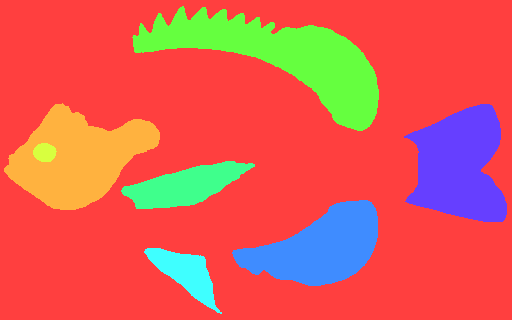

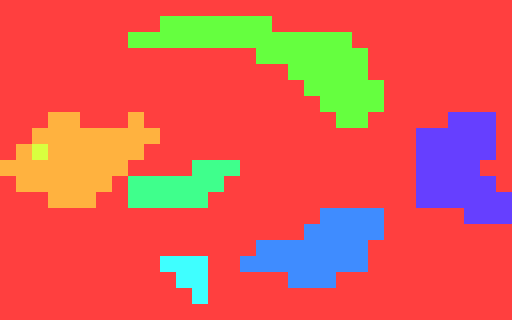

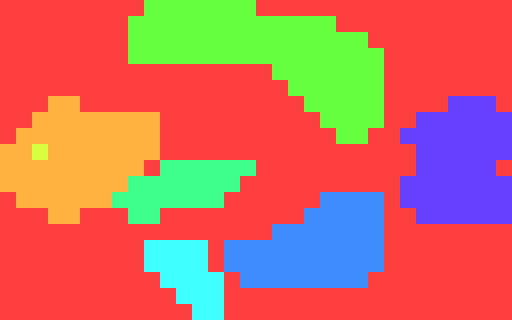

In [22]:
def show_sample(sample: dict[str, object]):
    pixel_labels_nd = sample["segmentation"]
    mode_labels_n = pixel_labels_nd.mode(axis=1).values
    patch_labels_n = patch_label_ignore_bg_bincount(
        pixel_labels_nd, background_idx=0, num_classes=10
    )

    p = 16
    hp, wp = sample["grid"].tolist()

    pixel_labels_hw = einops.rearrange(
        pixel_labels_nd,
        "(hp wp) (p1 p2) -> (hp p1) (wp p2)",
        p1=p,
        p2=p,
        hp=hp,
        wp=wp,
    )

    patch_labels_hw = einops.rearrange(patch_labels_n, "(hp wp) -> hp wp", hp=hp, wp=wp)
    patch_labels_hw = einops.repeat(patch_labels_hw, "h w -> (h p1) (w p2)", p1=p, p2=p)

    mode_labels_hw = einops.rearrange(mode_labels_n, "(hp wp) -> hp wp", hp=hp, wp=wp)
    mode_labels_hw = einops.repeat(mode_labels_hw, "h w -> (h p1) (w p2)", p1=p, p2=p)

    display(colorize_with_palette(pixel_labels_hw.numpy(), 10))
    display(colorize_with_palette(mode_labels_hw.numpy(), 10))
    display(colorize_with_palette(patch_labels_hw.numpy(), 10))


show_sample(dataset[0])

/tmp/ipykernel_1039004/796413477.py:22: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  im = Image.fromarray(lab, mode="P")


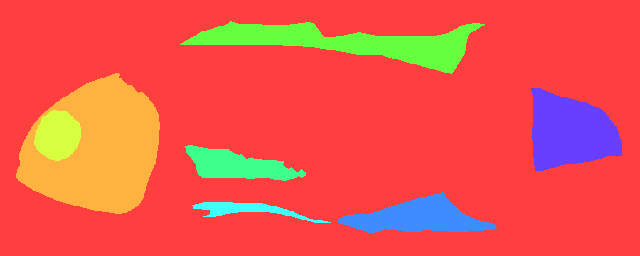

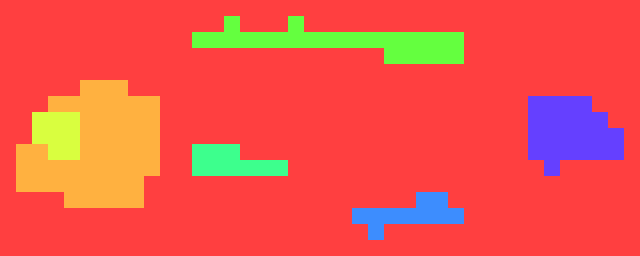

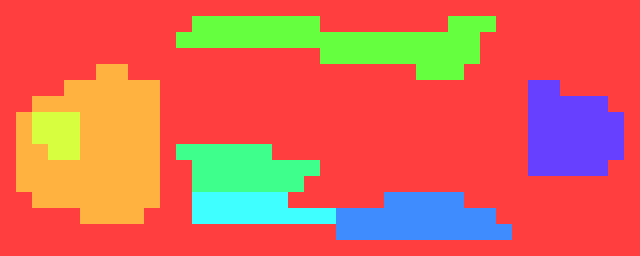

In [23]:
show_sample(dataset[10])

/tmp/ipykernel_1039004/796413477.py:22: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  im = Image.fromarray(lab, mode="P")


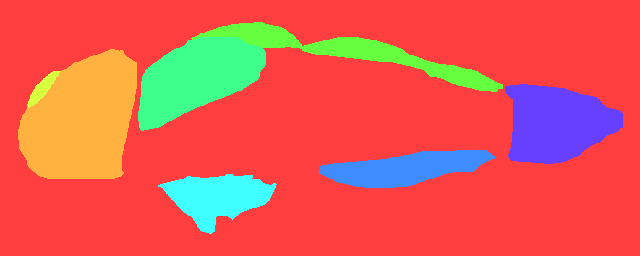

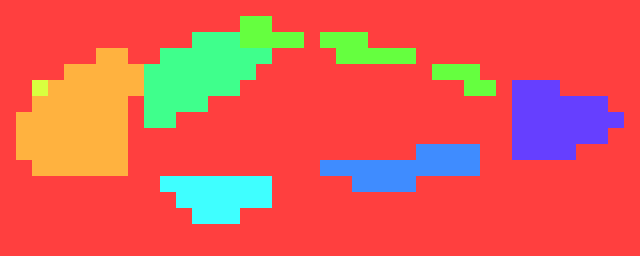

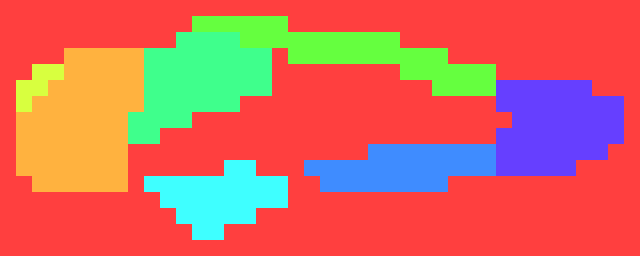

In [24]:
show_sample(dataset[100])

/tmp/ipykernel_1039004/796413477.py:22: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  im = Image.fromarray(lab, mode="P")


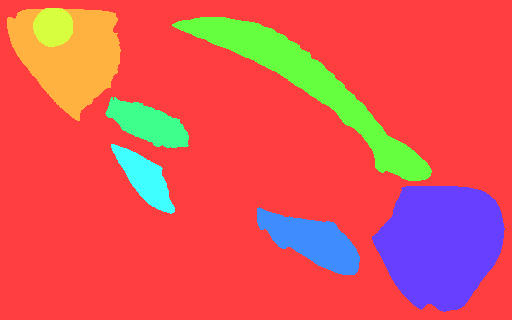

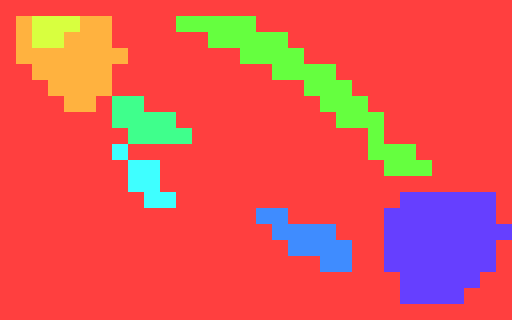

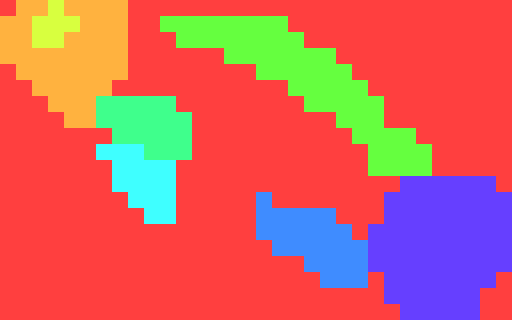

In [25]:
show_sample(dataset[1000])